In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorly.decomposition import parafac2
import tensorly as tl
from tensorly.parafac2_tensor import parafac2_to_slice
from tensorly.metrics.regression import variance as tl_var
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from tfac.figures.figureCommon import subplotLabel, getSetup
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

tl.set_backend("numpy")

def R2Xparafac2(tensor_slices, decomposition):
    """Calculate the R2X of parafac2 decomposition"""
    R2X = [0, 0]
    for idx, tensor_slice in enumerate(tensor_slices):
        reconstruction = parafac2_to_slice(decomposition, idx, validate=False)
        R2X[idx] = 1.0 - tl_var(reconstruction - tensor_slice) / tl_var(tensor_slice)
    return R2X


In [12]:
def get_patient_info():
    """Return specific patiend ID information"""
    dataCohort = pd.read_csv("tfac/data/mrsa/clinical_metadata_cohort1.txt", delimiter='\t')
    cohortID = list(dataCohort["sample"])
    statusID = list(dataCohort["outcome_txt"])

    return cohortID, statusID

def form_MRSA_tensor(variance=29):
    """Create list of data matrices for parafac2"""
    dfClin, dfCoh = importClinicalMRSA()
    dfCyto = clinicalCyto(dfClin, dfCoh)
    dfCyto = dfCyto.sort_values(by='sid')
    dfCyto = dfCyto.set_index('sid')
    cytokines = dfCyto.columns

    dfExp = importExpressionData()
    dfExp = dfExp.T
    geneIDs = dfExp.iloc[0, 0:].to_list()
    dfExp.columns = geneIDs
    dfExp = dfExp.drop('Geneid')

    cytoNumpy = dfCyto.to_numpy().T
    expNumpy = dfExp.to_numpy().T

    expNumpy = expNumpy.astype(float)
    var = (tl_var(expNumpy)/tl_var(cytoNumpy))
    cytoNumpy = cytoNumpy * variance
    

    tensor_slices = [cytoNumpy, expNumpy]

    return tensor_slices, cytokines, geneIDs

def importClinicalMRSA():
    """import clincal MRSA data"""
    dataClin = pd.read_csv("tfac/data/mrsa/mrsa_s1s2_clin+cyto_073018.csv")
    dataCohort = pd.read_csv("tfac/data/mrsa/clinical_metadata_cohort1.txt", delimiter='\t')
    return dataClin, dataCohort

def clinicalCyto(dataClinical, dataCohort):
    """isolate cytokine data from clinical"""
    rowSize, colSize = dataClinical.shape
    patientID = list(dataClinical["sid"])

    dataClinical = dataClinical.drop(dataClinical.iloc[:, 0:3], axis=1)
    dataClinical = dataClinical.drop(dataClinical.iloc[:, 1:207], axis=1)

    """isolate patient IDs from cohort 1"""
    dataCohort = dataCohort.drop(columns=['age', 'gender', 'race', 'sampletype', 'pair', 'outcome_txt'], axis=1)
    cohortID = list(dataCohort["sample"])
    IDSize, column = dataCohort.shape

    cytokineData = pd.DataFrame()

    for y in range(0, rowSize):
        for z in range(0, IDSize):
            if (cohortID[z]).find(str(patientID[y])) != -1:
                temp = dataClinical.loc[dataClinical['sid'] == patientID[y]]
                cytokineData = pd.concat([temp, cytokineData])
    cytokineData.sort_values(by=['sid'])
    return cytokineData

def importExpressionData():
    """import expression data"""
    df = pd.read_table("tfac/data/mrsa/expression_counts_cohort1.txt")
    df.drop(["Chr", "Start", "End", "Strand", "Length"], inplace=True, axis=1)
    return df

0.6557377049180327
0.6065573770491803


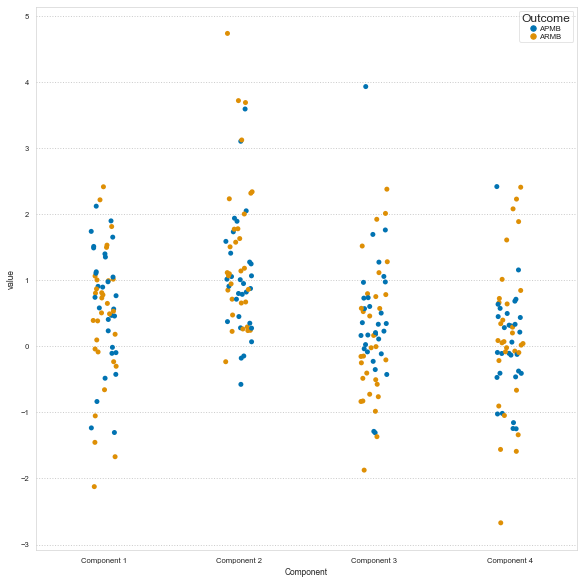

In [13]:
tensor_slices, cytokines, geneIDs = form_MRSA_tensor()
components = 4
parafac2tensor = parafac2(tensor_slices, components, random_state=1)
cohortID, outcomeID = get_patient_info()

patient_matrix = parafac2tensor[1][2]


outcome_bools = []

for outcome in outcomeID:
    if outcome == 'APMB':
        outcome_bools.append(0)
    else:
        outcome_bools.append(1)

outcomes = np.asarray(outcome_bools)


clf = LogisticRegression(random_state=1).fit(patient_matrix, outcomes)
c = clf.score(patient_matrix, outcomes)
print(c)


'''true_y = outcomes
score_y = clf.decision_function(patient_matrix)
fpr, tpr, thresholds = roc_curve(true_y, score_y)
auc = roc_auc_score(true_y, score_y)
print(auc)
df = pd.DataFrame()
df['FPR'] = fpr
df['TPR'] = tpr
ax, f = getSetup((8, 8), (1, 1))
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
df = pd.DataFrame()
df['FPR'] = [0, 1]
df['TPR'] = [0, 1]
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])'''


kf = KFold(n_splits=61)
c = []
for train, test in kf.split(patient_matrix):
    clf = LogisticRegression(random_state=1).fit(patient_matrix[train], outcomes[train])
    c.append(clf.score(patient_matrix[test], outcomes[test]))
print(sum(c) / len(c))





patient_df = pd.DataFrame(patient_matrix)
patient_df['Outcome'] = outcomeID
columns = []
for component in range(1, components + 1):
    columns.append('Component ' + str(component))
columns.append('Outcome')
patient_df.columns = columns

patient_df = pd.melt(patient_df, id_vars=['Outcome'], var_name='Component')



ax, f = getSetup((8, 8), (1, 1))
sns.stripplot(data=patient_df, x='Component', y='value', hue='Outcome')



#print(tl_var(tensor_slices[1])/tl_var(tensor_slices[0]))

AllR2X = []
for i in range(1, 21):
    parafac2tensor = parafac2(tensor_slices, i, random_state=1)
    AllR2X.append(R2Xparafac2(tensor_slices, parafac2tensor))
df = pd.DataFrame(AllR2X)
plt.savefig('Components', dpi = 1200)

In [120]:
tensor_slices, cytokines, geneIDs = form_MRSA_tensor(29)
components = 10

AllR2X = []
for i in range(1, components + 1):
    parafac2tensor = parafac2(tensor_slices, i, random_state=1)
    AllR2X.append(R2Xparafac2(tensor_slices, parafac2tensor))
df = pd.DataFrame(AllR2X)

comps = []
for i in range(1, components + 1):
    comps.append(i)
df['Component'] = comps


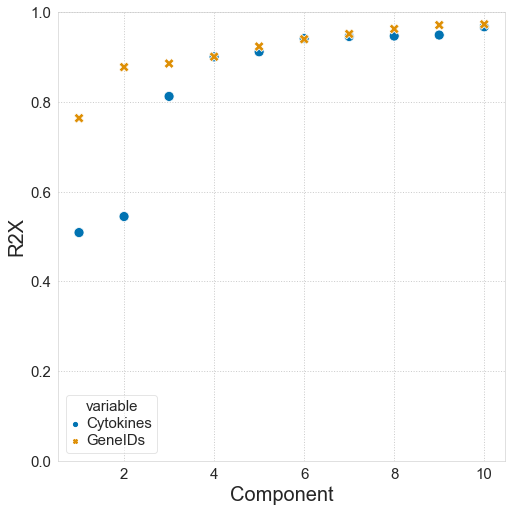

In [122]:
df.columns = ['Cytokines', 'GeneIDs', 'Component']
test = pd.melt(df, id_vars=['Component'])
ax, f = getSetup((7, 7), (1, 1))
b = sns.scatterplot(data=test, x='Component', y='value', hue='variable', style='variable', ax=ax[0], s=100)
b.set_xlabel("Component",fontsize=20)
b.set_ylabel("R2X",fontsize=20)
b.tick_params(labelsize=15)
plt.legend(prop={'size': 15})
ax[0].set_ylim(0, 1)
plt.savefig('R2X_equal', dpi = 300)

In [16]:
#clf = LogisticRegression(random_state=1).fit(patient_matrix, outcomes)
#c = clf.score(patient_matrix, outcomes)

kf = KFold(n_splits=61)
c = []
for train, test in kf.split(patient_matrix):
    clf = LogisticRegression(random_state=1).fit(patient_matrix[train], outcomes[train])
    c.append(clf.decision_function(patient_matrix[test]))

0.5698924731182796


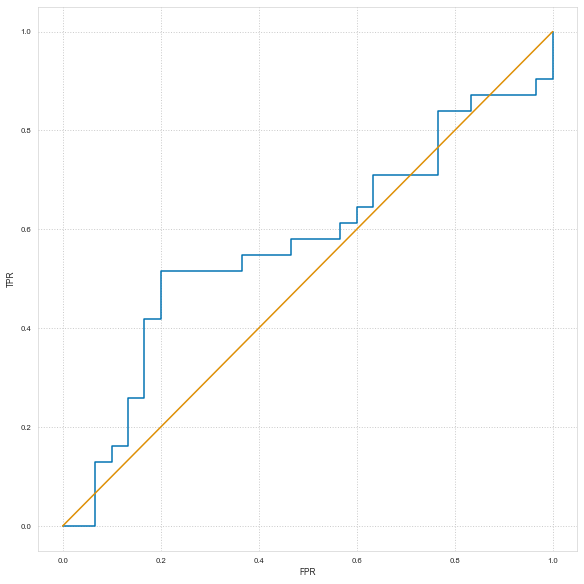

In [17]:
true_y = outcomes
score_y = c

fpr, tpr, thresholds = roc_curve(true_y, score_y)
auc = roc_auc_score(true_y, score_y)
print(auc)
df = pd.DataFrame()
df['FPR'] = fpr
df['TPR'] = tpr
ax, f = getSetup((8, 8), (1, 1))
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
df = pd.DataFrame()
df['FPR'] = [0, 1]
df['TPR'] = [0, 1]
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
plt.savefig('ROC_curve', dpi = 1200)

In [24]:
tensor_slices, cytokines, geneIDs = form_MRSA_tensor()
components = 4
parafac2tensor = parafac2(tensor_slices, components, random_state=1)

patient_matrix = parafac2tensor[1][2]
kf = KFold(n_splits=61)
decisions = []
for train, test in kf.split(patient_matrix):
    clf = SVC(random_state=1)
    clf.fit(patient_matrix[train], outcomes[train])
    decisions.append(clf.decision_function(patient_matrix[test]))

0.578494623655914


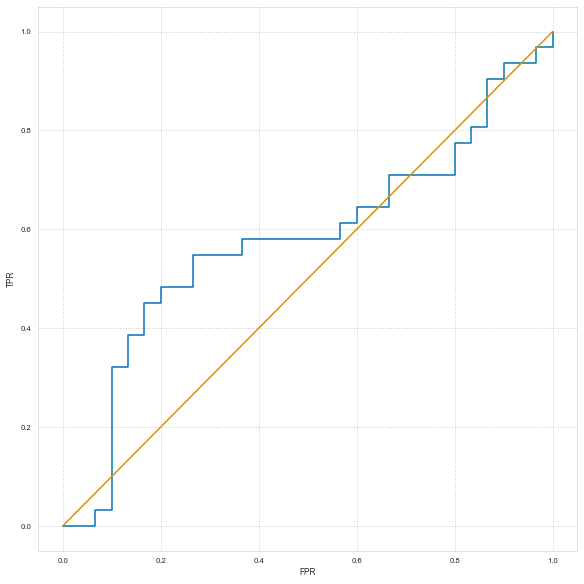

In [25]:
true_y = outcomes
score_y = decisions

fpr, tpr, thresholds = roc_curve(true_y, score_y)
auc = roc_auc_score(true_y, score_y)
print(auc)
df = pd.DataFrame()
df['FPR'] = fpr
df['TPR'] = tpr
ax, f = getSetup((8, 8), (1, 1))
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
df = pd.DataFrame()
df['FPR'] = [0, 1]
df['TPR'] = [0, 1]
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
plt.savefig('ROC_curve', dpi = 1200)

In [10]:
tensor_slices, cytokines, geneIDs = form_MRSA_tensor()
components = 4 
parafac2tensor = parafac2(tensor_slices, components, random_state=1)
cohortID, outcomeID = get_patient_info()

patient_matrix = parafac2tensor[1][2]

clf = SVC(random_state=1)
clf.fit(patient_matrix, outcomes)
print(clf.score(patient_matrix, outcomes))
kf = KFold(n_splits=61)
c = []
for train, test in kf.split(patient_matrix):
    clf = SVC(random_state=1)
    clf.fit(patient_matrix[train], outcomes[train])
    c.append(clf.score(patient_matrix[test], outcomes[test]))
print(sum(c) / len(c))

0.7049180327868853
0.6065573770491803


Plot roc at var 1 and comp 31 and maybe var 29 and comp 31
Plot AUC vs var at comp 31
Plot AUC vs comp # at var 1

0.7634408602150538


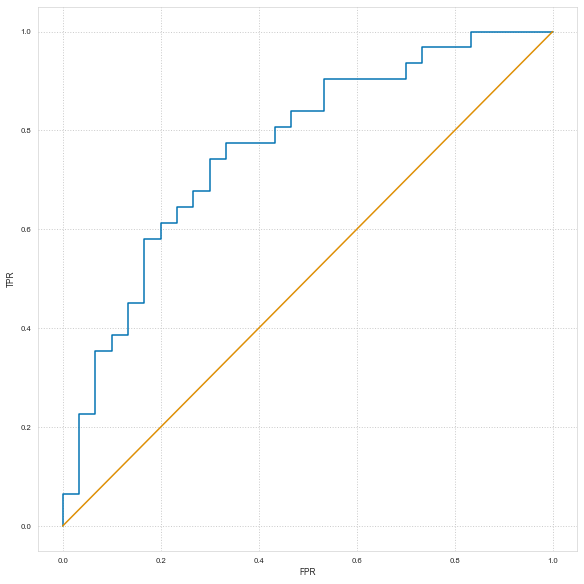

In [52]:
tensor_slices, cytokines, geneIDs = form_MRSA_tensor(1)
components = 38
parafac2tensor = parafac2(tensor_slices, components, random_state=1)

patient_matrix = parafac2tensor[1][2]
kf = KFold(n_splits=61)
decisions = []
for train, test in kf.split(patient_matrix):
    clf = LogisticRegression(random_state=1, max_iter=10000).fit(patient_matrix[train], outcomes[train])
    decisions.append(clf.decision_function(patient_matrix[test]))
true_y = outcomes
score_y = decisions

fpr, tpr, thresholds = roc_curve(true_y, score_y)
auc = roc_auc_score(true_y, score_y)
print(auc)
df = pd.DataFrame()
df['FPR'] = fpr
df['TPR'] = tpr
ax, f = getSetup((8, 8), (1, 1))
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
df = pd.DataFrame()
df['FPR'] = [0, 1]
df['TPR'] = [0, 1]
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
plt.savefig('ROC_curve_var1comp31', dpi = 300)

0.7634408602150538


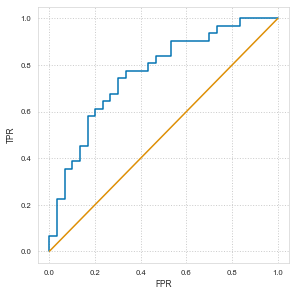

In [57]:
fpr, tpr, thresholds = roc_curve(true_y, score_y)
auc = roc_auc_score(true_y, score_y)
print(auc)
df = pd.DataFrame()
df['FPR'] = fpr
df['TPR'] = tpr
ax, f = getSetup((4, 4), (1, 1))
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
df = pd.DataFrame()
df['FPR'] = [0, 1]
df['TPR'] = [0, 1]
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
plt.savefig('ROC_curve_var1comp38', dpi = 600)

0.6602150537634409


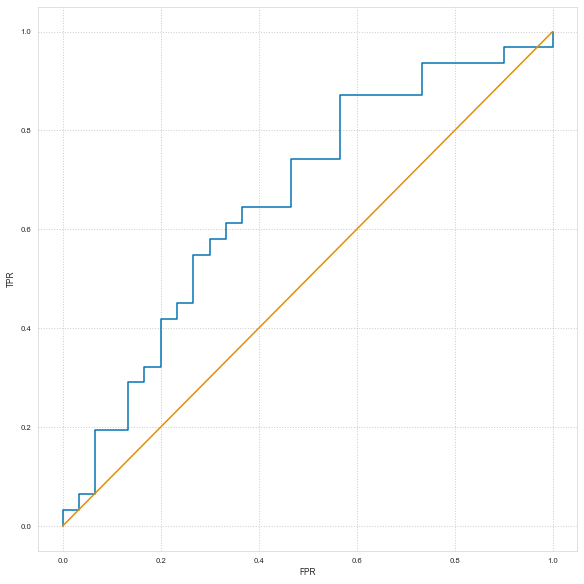

In [28]:
tensor_slices, cytokines, geneIDs = form_MRSA_tensor(29)
components = 31
parafac2tensor = parafac2(tensor_slices, components, random_state=1)

patient_matrix = parafac2tensor[1][2]
kf = KFold(n_splits=61)
decisions = []
for train, test in kf.split(patient_matrix):
    clf = LogisticRegression(random_state=1, max_iter=10000).fit(patient_matrix[train], outcomes[train])
    decisions.append(clf.decision_function(patient_matrix[test]))
true_y = outcomes
score_y = decisions

fpr, tpr, thresholds = roc_curve(true_y, score_y)
auc = roc_auc_score(true_y, score_y)
print(auc)
df = pd.DataFrame()
df['FPR'] = fpr
df['TPR'] = tpr
ax, f = getSetup((8, 8), (1, 1))
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
df = pd.DataFrame()
df['FPR'] = [0, 1]
df['TPR'] = [0, 1]
sns.lineplot(data=df, x='FPR', y='TPR', estimator=None, ax=ax[0])
plt.savefig('ROC_curve_var29comp31', dpi = 1200)

In [46]:
values_vars = []
for variance in [.001, .1, 1, 2.25, 5, 10, 15, 20, 29, 50, 100, 1000, 10000, 100000]:
    tensor_slices, cytokines, geneIDs = form_MRSA_tensor(variance)
    components = 30
    parafac2tensor = parafac2(tensor_slices, components, random_state=1)

    patient_matrix = parafac2tensor[1][2]


    kf = KFold(n_splits=61)
    decisions = []
    for train, test in kf.split(patient_matrix):
        clf = LogisticRegression(random_state=1, max_iter=10000).fit(patient_matrix[train], outcomes[train])
        decisions.append(clf.decision_function(patient_matrix[test]))
    score_y = decisions
    auc = roc_auc_score(true_y, score_y)
    values_vars.append([variance, auc])
df_var = pd.DataFrame(values_vars)

In [77]:
values_comps = []
for components in range(1, 41):
    tensor_slices, cytokines, geneIDs = form_MRSA_tensor(1)
    parafac2tensor = parafac2(tensor_slices, components, random_state=1)

    patient_matrix = parafac2tensor[1][2]


    kf = KFold(n_splits=61)
    decisions = []
    for train, test in kf.split(patient_matrix):
        clf = LogisticRegression(random_state=1, max_iter=10000).fit(patient_matrix[train], outcomes[train])
        decisions.append(clf.decision_function(patient_matrix[test]))
    score_y = decisions
    auc = roc_auc_score(true_y, score_y)
    values_comps.append([components, auc])
df_comp = pd.DataFrame(values_comps)

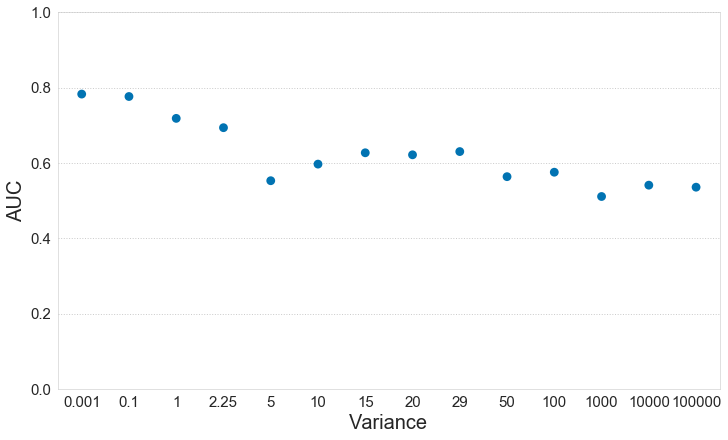

In [73]:
df_var.columns = ['Variance', 'AUC']
ax, f = getSetup((10, 6), (1, 1))

b = sns.pointplot(data=df_var, x='Variance', y='AUC', join=False, ax=ax[0])
b.set_xlabel("Variance",fontsize=20)
b.set_ylabel("AUC",fontsize=20)
b.tick_params(labelsize=15)
b.set_xticklabels([.001, .1, 1, 2.25, 5, 10, 15, 20, 29, 50, 100, 1000, 10000, 100000])
ax[0].set_ylim(0, 1)
plt.savefig('AUC_30comps_variance', dpi = 300)


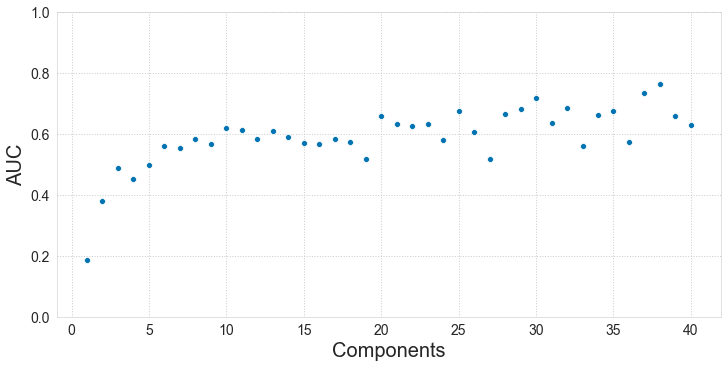

In [89]:
df_comp.columns = ['Components', 'AUC']
ax, f = getSetup((10, 5), (1, 1))
b = sns.scatterplot(data=df_comp, x='Components', y='AUC', ax=ax[0])
b.set_xlabel("Components",fontsize=20)
b.set_ylabel("AUC",fontsize=20)
b.tick_params(labelsize=14)
ax[0].set_ylim(0, 1)
plt.savefig('AUC_var1_comps', dpi = 300)